**Load python libraries**

In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import os.path
import xarray as xr
import pandas as pd
import numpy as np
import requests
import netCDF4
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from IPython.display import Image, display
from dask.distributed import Client, progress
from glob import glob
import colorsys
from matplotlib.colors import LinearSegmentedColormap # Linear interpolation for color maps
import pylab as pl
from shapely.geometry import Point
from descartes import PolygonPatch
import wrf
from scipy import stats
from statistics import median

In [3]:
latitude=34.5
longitude=359.375-119.375

filename =  '/home/sbarc/students/nash/data/ar_catalog/globalARcatalog_MERRA2_1980-2019_v2.0.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds = ds.squeeze()

ds_SB = ds.sel(lat=latitude, lon=longitude)
ds_SB = ds_SB.squeeze()
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds.info()

ds size in GB 290.43

xarray.Dataset {
dimensions:
	lat = 361 ;
	limitID = 5 ;
	lon = 576 ;
	stageID = 9 ;
	time = 57584 ;

variables:
	float32 shape(time, lat, lon) ;
		shape:long_name = Shape ;
		shape:units = none ;
	float64 axis(time, lat, lon) ;
		axis:long_name = Axis ;
		axis:units = none ;
	float64 tnsct(time, lat, lon) ;
		tnsct:long_name = Transect ;
		tnsct:units = none ;
	float32 lfloc(time, lat, lon) ;
		lfloc:long_name = Landfall Location ;
		lfloc:units = none ;
	float32 islnd(lat, lon) ;
		islnd:long_name = Is Land (Major Landmasses Only) ;
	float32 iscst(lat, lon) ;
		iscst:long_name = Is Coast (Major Landmasses Only; Inland Water Bodies Not Considered) ;
	float64 lon(lon) ;
		lon:units = degrees_east ;
	float64 lat(lat) ;
		lat:units = degrees_north ;
	float64 lev() ;
		lev:units = m ;
	datetime64[ns] time(time) ;
		time:ntime_written = 56980.0 ;
	float64 ens() ;
		ens:axis = e ;
	float32 year(time, lon) ;
		year:long_name = Year ;
		year:units = none ;
	float32 month

In [4]:
def get_ivt_direction(ds1, ds2):
    da = ds1.shape.dropna(dim='time') ## drop the times where there is no AR present
    idx_times = np.unique(da['time']) ## list of days where AR is present in loc
    times_list = pd.DatetimeIndex(idx_times) ## create a pandas datetime index for easy time use
    ds_new = ds2.sel(time=times_list) # get only AR days

    ## get the ivt direction of the AR object that is over SB
    ivtdir = []
    idx_shape = da.values.astype(int) # get integer index values of ar object
    for i in range(len(times_list)):
        ivtdir.append(ds_new.ivtdir[i].isel(lon=idx_shape[i]).values)
    ivtdir = np.asarray(ivtdir)
    
    return(ivtdir)

In [5]:
## get ivt direction for all AR events in SB
ivtdir = get_ivt_direction(ds_SB, ds)
print(ivtdir.shape)

## get ivt direction for AR events in march only
def is_mar(month):
    return (month == 3)

ds_march = ds_SB.sel(time=is_mar(ds['time.month']))
ivtdir_march = get_ivt_direction(ds_march, ds)
print(ivtdir_march.shape)

(3779,)
(384,)


In [8]:
## Get direction of specific event ivt direction
ds_event = ds.sel(time='2019-03-05 12:00')
da = ds_SB.shape.dropna(dim='time') ## drop the times where there is no AR present
idx_event = da.sel(time= '2019-03-05 12:00')
ivtdir_event = ds_event.ivtdir.isel(lon=idx_event.astype(int))
print('IVT Direction during March AR Event:', ivtdir_event.values)

IVT Direction during March AR Event: 56.51005


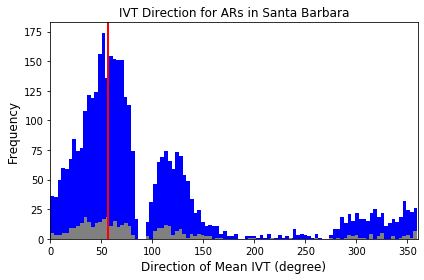

In [14]:
results = [ivtdir, ivtdir_march]
n_bins = 100
fig, axs = plt.subplots(1, 1, tight_layout=True)
subtitles = ['All ARs in SB', 'March ARs in SB']

# We can set the number of bins with the `bins` kwarg
 
axs.hist(results[0], bins=n_bins, facecolor='blue')
axs.hist(results[1], bins=n_bins, facecolor='grey')
axs.axvline(ivtdir_event.values, color='r', linestyle='-', linewidth=2)
axs.set_xlim(0, 360)
axs.set_xlabel('Direction of Mean IVT (degree)', fontsize=12)
axs.set_ylabel('Frequency', fontsize=12)
axs.title.set_text('IVT Direction for ARs in Santa Barbara')

#### Import MERRA2 0* Isotherm Data for AR Days only

In [2]:
filename = '/home/sbarc/students/nash/data/MERRA-2/SB_AR_0_degree_isotherm.nc'
ds = xr.open_dataset(filename)

Check for 0* crossings in the temperature profile between 1000 and 200 hPa.
If single zero crossing, altitude is taken as the freezing level.
Special case 1: No zero crossing (T < 0degC throughout column)
Flag freezing level as missing.
Special case 2: Multiple zero crossing due to temperature inversion
Flag all locations, store only lowest Z0 value

In [15]:
ds.T.sel(lat=30.0, lon=-125.0, time='1980-01-09').values - 273.15

array([[ 17.207642 ,  15.367401 ,  13.745148 ,  11.937164 ,  10.579376 ,
          9.087982 ,   7.4539185,   5.849518 ,   4.2979126,   2.897583 ,
          1.3445129,  -0.2447815,  -1.8721313,  -5.5278625,  -9.589111 ,
        -13.769836 , -18.557083 , -24.119537 , -30.636566 , -38.080414 ,
        -45.878098 , -51.612625 , -52.505768 ]], dtype=float32)

In [16]:
ht = ds.H
t = ds.T - 273.15 # convert to Kelvin

interp_results = wrf.interplevel(ht, t, 0.0, missing=np.nan)
interp_results

<xarray.DataArray 'H_interp' (time: 1814, lat: 21, lon: 17)>
array([[[2701.0605 , 2728.6125 , ..., 2932.267  , 3041.6162 ],
        [2671.9265 , 2689.3518 , ..., 2908.5576 , 3014.3623 ],
        ...,
        [2017.6572 , 1992.1548 , ..., 2478.097  , 2415.031  ],
        [1901.4426 , 1895.7856 , ..., 2493.814  , 2460.3137 ]],

       [[3598.8027 , 3512.3945 , ..., 2799.9124 , 3052.0586 ],
        [3454.891  , 3361.2385 , ..., 2770.3223 , 3056.1187 ],
        ...,
        [1004.77997, 1037.0061 , ..., 2245.4788 , 2296.6375 ],
        [ 982.4503 ,  982.22235, ..., 2188.122  , 2255.6445 ]],

       ...,

       [[4958.35   , 4965.287  , ..., 5016.5444 , 5033.6914 ],
        [4911.756  , 4935.4595 , ..., 5047.163  , 4993.8774 ],
        ...,
        [3444.9836 , 3468.0115 , ..., 3653.9617 , 3656.36   ],
        [3384.4785 , 3432.9365 , ..., 3584.577  , 3608.571  ]],

       [[4213.42   , 4239.8345 , ..., 4753.1655 , 4774.007  ],
        [4174.8843 , 4190.6714 , ..., 4743.088  , 4728.54   ],

In [17]:
interp_results.lon

<xarray.DataArray 'lon' (lon: 17)>
array([-125.   , -124.375, -123.75 , -123.125, -122.5  , -121.875, -121.25 ,
       -120.625, -120.   , -119.375, -118.75 , -118.125, -117.5  , -116.875,
       -116.25 , -115.625, -115.   ])
Coordinates:
  * lon      (lon) float64 -125.0 -124.4 -123.8 -123.1 ... -116.2 -115.6 -115.0
    level    float64 0.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [18]:
## select SB
latitude=34.5
longitude=-119.375

SB_results = interp_results.sel(lat=latitude, lon=longitude)

## select only March events
def is_mar(month):
    return (month == 3)

ds_march = interp_results.sel(time=is_mar(interp_results['time.month']), lat=latitude, lon=longitude)
ds_march

<xarray.DataArray 'H_interp' (time: 170)>
array([2626.2974, 2242.571 , 1901.8168, 3068.9912, 1801.7705, 1963.5237,
       2256.1301, 3279.135 , 3632.4856, 3127.7463, 3305.712 , 3177.5159,
       2261.1553, 1558.5488, 2474.6123, 1409.7407, 2186.1562, 2456.855 ,
             nan, 1966.726 , 2557.8716, 3017.712 , 3332.0159, 3466.5903,
       1991.9781, 2266.4978, 2634.7563, 3478.7983, 3916.1326, 3326.6904,
       3445.818 , 2698.1594, 4025.9702, 4191.3833, 2887.9407, 2146.6245,
       1493.9425, 3568.44  , 3297.325 , 2226.287 , 3756.794 , 3287.252 ,
       2571.888 , 2987.4297, 2202.794 , 4169.0015, 3031.9534, 3332.4927,
       3886.8108, 4055.182 , 3676.201 , 3461.4758, 3906.9421, 3713.2336,
       3688.1768, 3720.3264, 3173.163 , 3586.2158, 3974.251 , 2867.6494,
       3853.3103, 3376.1506, 3351.0366, 2331.7085, 3493.985 , 2155.6086,
       1972.2051, 2964.162 , 3421.438 , 3192.9841, 1800.5305, 1500.7511,
       1938.0951, 1668.3403, 1650.2305, 2139.5215, 2822.3267, 2384.6125,
       20

In [28]:
def preprocess(ds):
    '''keep only the selected lats and lons'''
    return ds.sel(latitude=latitude, longitude=360.-119.5)

filename_pattern =  '/home/sbarc/students/nash/data/CFSv2/netcdf_CFSv2_vertical_levels/201*'
ds = xr.open_mfdataset(filename_pattern, engine='netcdf4', preprocess=preprocess)
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds = ds.sel(time=slice('2019-03-06-12', '2019-03-06-18'))
zero_isotherm = ds.hgt_0Cisotherm
print(zero_isotherm.values)
zeroiso_event = np.mean(zero_isotherm.values)

ds size in GB 0.00

[2606.4  2279.84]


In [51]:
print(np.nanmean(SB_results.values))
# SB_results.values
print(np.nanmean(ds_march.values))

3530.9973
2882.1235


In [36]:
len(SB_results)

1814

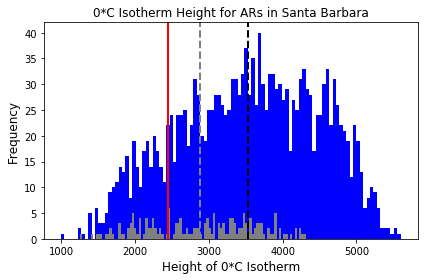

In [53]:
results = [SB_results.values, ds_march.values]
n_bins = 100
fig, axs = plt.subplots(1, 1, tight_layout=True)
subtitles = ['All ARs in SB', 'March ARs in SB']

# We can set the number of bins with the `bins` kwarg
 
axs.hist(results[0], bins=n_bins, facecolor='blue')
axs.hist(results[1], bins=n_bins, facecolor='grey')
axs.axvline(zeroiso_event, color='r', linestyle='-', linewidth=2)
axs.axvline(np.nanmean(SB_results.values), color='k', linestyle='--', linewidth=2)
axs.axvline(np.nanmean(ds_march.values), color='grey', linestyle='--', linewidth=2)
# axs.set_xlim(0, 360)
axs.set_xlabel('Height of 0*C Isotherm', fontsize=12)
axs.set_ylabel('Frequency', fontsize=12)
axs.title.set_text('0*C Isotherm Height for ARs in Santa Barbara')

In [41]:
## Compare # ARs in Cannon et al., 2017 to Guan and Waliser 2015
latitude=34.5
longitude=359.375-119.375

filename =  '/home/sbarc/students/nash/data/ar_catalog/globalARcatalog_MERRA2_1980-2019_v2.0.nc'
ds = xr.open_dataset(filename, engine='netcdf4')
ds = ds.squeeze()

## select only March events
def is_ondjfm(month):
    return (month >= 10) | (month <=3)

ds_cannon = ds.sel(time=slice('2014-10-01', '2017-03-31'), lat=slice(20., 60.), lon=slice(360-160, 360-110))
ds_cannon = ds_cannon.sel(time=is_ondjfm(ds_cannon['time.month']))
ds_cannon = ds_cannon.squeeze()
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds_cannon


ds size in GB 290.43



<xarray.Dataset>
Dimensions:    (lat: 81, limitID: 5, lon: 81, stageID: 9, time: 2188)
Coordinates:
  * lon        (lon) float64 200.0 200.6 201.2 201.9 ... 248.1 248.8 249.4 250.0
  * lat        (lat) float64 20.0 20.5 21.0 21.5 22.0 ... 58.5 59.0 59.5 60.0
    lev        float64 1e+03
  * time       (time) datetime64[ns] 2014-10-01 ... 2017-03-31T18:00:00
    ens        float64 1.0
  * stageID    (stageID) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * limitID    (limitID) float64 1.0 2.0 3.0 4.0 5.0
Data variables:
    shape      (time, lat, lon) float32 ...
    axis       (time, lat, lon) float64 ...
    tnsct      (time, lat, lon) float64 ...
    lfloc      (time, lat, lon) float32 ...
    islnd      (lat, lon) float32 ...
    iscst      (lat, lon) float32 ...
    year       (time, lon) float32 ...
    month      (time, lon) float32 ...
    day        (time, lon) float32 ...
    hour       (time, lon) float32 ...
    length     (time, lon) float32 ...
    width      (time, lon) f

In [47]:
da = ds_cannon.shape.count(dim='time')
da.min()

<xarray.DataArray 'shape' ()>
array(79)
Coordinates:
    lev      float64 1e+03
    ens      float64 1.0

In [46]:
da.sel(lat=latitude, lon=longitude)

<xarray.DataArray 'shape' ()>
array(195)
Coordinates:
    lon      float64 240.0
    lat      float64 34.5
    lev      float64 1e+03
    ens      float64 1.0

In [48]:
da.max()

<xarray.DataArray 'shape' ()>
array(455)
Coordinates:
    lev      float64 1e+03
    ens      float64 1.0

In [49]:
## select only months between november and april
def is_ndjfma(month):
    return (month >= 11) | (month <=4)

ds_rutz = ds.sel(time=slice('1988-11-01', '2011-04-30'), lat=latitude, lon=longitude)
ds_rutz = ds_rutz.sel(time=is_ndjfma(ds_rutz['time.month']))
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))
ds_rutz

ds size in GB 290.43



<xarray.Dataset>
Dimensions:    (limitID: 5, stageID: 9, time: 16672)
Coordinates:
    lon        float64 240.0
    lat        float64 34.5
    lev        float64 1e+03
  * time       (time) datetime64[ns] 1988-11-01 ... 2011-04-30T18:00:00
    ens        float64 1.0
  * stageID    (stageID) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0
  * limitID    (limitID) float64 1.0 2.0 3.0 4.0 5.0
Data variables:
    shape      (time) float32 ...
    axis       (time) float64 ...
    tnsct      (time) float64 ...
    lfloc      (time) float32 ...
    islnd      float32 ...
    iscst      float32 ...
    year       (time) float32 ...
    month      (time) float32 ...
    day        (time) float32 ...
    hour       (time) float32 ...
    length     (time) float32 ...
    width      (time) float32 ...
    clon       (time) float32 ...
    clat       (time) float32 ...
    tlon       (time) float32 ...
    tlat       (time) float32 ...
    hlon       (time) float32 ...
    hlat       (time) float32 

In [50]:
da_rutz = ds_rutz.shape.count(dim='time')
da_rutz

<xarray.DataArray 'shape' ()>
array(1389)
Coordinates:
    lon      float64 240.0
    lat      float64 34.5
    lev      float64 1e+03
    ens      float64 1.0